# Astrobrowser - Herschel Reference Survey

Explore the HiPS maps available for the galaxies in the HRS and compute aperture photometry.

# 1. Initialisation

## System setup

In [1]:
%matplotlib ipympl
import os
import numpy as np
from scipy import special
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator
from matplotlib.backends.backend_pdf import PdfPages
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.table import Table, QTable, hstack
from astropy import units as u
from astropy import constants as c
from scripts import astrobrowser
from photutils.aperture import SkyEllipticalAperture
import importlib

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
output_dir = os.path.join('HRS', 'output')
if not os.path.isdir(output_dir):
    print(f'>> WARNING: Creating output directory: "{output_dir}"')
    os.makedirs(output_dir)

## Read HRS catalogues

In [4]:
HRS_optical_UV_catalogue = Table.read(os.path.join('HRS', 'optical_UV_cortese_2012', 'table1.dat'), format='ascii.commented_header')
HRS_optical_UV_photometry = Table.read(os.path.join('HRS', 'optical_UV_cortese_2012', 'table2.dat'), format='ascii.commented_header')

In [5]:
HRS_optical_UV_catalogue

HRS,CGCG,VCC,UGC,NGC,IC,R.A.,Dec.,Type,D_25,E(B-V),Dist.,Tile-Name_NUV,texp_NUV,Tile-Name_FUV,texp_FUV,NOTE
int64,str7,str4,str4,str4,str4,str11,str11,int64,float64,float64,float64,str28,str8,str28,str8,str3
1,123-035,...,...,...,...,10:17:39.66,+22:48:35.9,13,1.0,0.0311,16.79,GI6_012001_HRS1,1385.7,...,...,N
2,124-004,...,5588,...,...,10:20:57.13,+25:21:53.4,5,0.52,0.023,18.44,GI6_012002_HRS2,1669.1,AIS_213,201.0,...
3,94-026,...,5617,3226,...,10:23:27.01,+19:53:54.7,0,3.16,0.0226,16.7,...,...,...,...,S
4,94-028,...,5620,3227,...,10:23:30.58,+19:51:54.2,3,5.37,0.0226,16.4,...,...,...,...,S
5,94-052,...,...,...,610,10:26:28.37,+20:13:41.5,7,1.86,0.0203,16.71,...,...,...,...,S
6,154-016,...,5662,...,...,10:27:01.16,+28:38:21.9,5,3.31,0.0267,18.89,GI3_079013_NGC3245,1622.15,GI3_079013_NGC3245,1622.15,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,47-066,...,9311,...,1022,14:30:01.85,+03:46:22.3,5,1.1,0.033,24.51,MISDR1_33710_0585,1690.1,MISDR1_33710_0585,1690.1,...
318,47-070,...,9328,5645,...,14:30:39.35,+07:16:30.3,9,2.4,0.0272,19.57,MISWZN15_33606_0360,1684.05,MISWZN15_33606_0360,1684.05,...


In [6]:
HRS_optical_UV_photometry

HRS,e,PA,FUV_asy,eFUV_asy,FUV_D25,eFUV_D25,NUV_asy,eNUV_asy,NUV_D25,eNUV_D25,g_asy,eg_asy,g_D25,eg_D25,r_asy,er_asy,r_D25,er_D25,i_asy,ei_asy,i_D25,ei_D25,log(M*)
int64,float64,int64,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str6,str5,str5
1,0.6,-5,...,...,...,...,17.680,0.031,17.759,0.034,14.870,0.030,14.944,0.032,14.233,0.021,14.307,0.023,13.899,0.031,13.995,0.032,8.72
2,0.28,35,16.322,0.059,16.488,0.092,15.878,0.030,16.034,0.071,13.951,0.030,14.083,0.066,13.480,0.020,13.612,0.060,13.259,0.030,13.407,0.064,8.77
3,0.17,17,...,...,...,...,...,...,...,...,11.821,0.036,11.975,0.036,11.078,0.022,11.220,0.022,10.661,0.031,10.809,0.032,10.21
4,0.48,-33,...,...,...,...,...,...,...,...,11.189,0.034,11.256,0.036,10.552,0.021,10.599,0.022,10.162,0.031,10.214,0.031,10.26
5,0.76,29,...,...,...,...,...,...,...,...,13.920,0.034,14.040,0.033,13.057,0.023,13.164,0.022,12.590,0.032,12.674,0.032,9.62
6,0.85,-30,17.499,0.052,17.628,0.055,17.005,0.032,17.114,0.034,14.489,0.032,14.632,0.034,13.923,0.029,14.046,0.026,13.545,0.038,13.742,0.042,8.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.65,-20,17.153,0.051,17.307,0.055,16.788,0.032,16.975,0.037,14.634,0.030,14.748,0.037,14.138,0.022,14.248,0.029,13.803,0.032,13.952,0.040,8.94
318,0.43,80,14.831,0.050,14.864,0.050,14.367,0.030,14.414,0.030,12.380,0.031,12.500,0.032,11.939,0.021,12.080,0.022,11.698,0.031,11.863,0.033,9.43


In [7]:
HRS_PACS_catalogue = QTable.read(os.path.join('HRS', 'PACS_cortese_2014_table2.vot'))
HRS_PACS_catalogue

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]


HRS,CGCG,VCC,UGC,NGC,IC,R.A.__J.2000_,Dec__J.2000_,Type,FLAG_100,F_100,sigma_100,FLAG_160,F_160,sigma_160,a,b,P.A.,Proposal_ID
,,,,,,hms,dms,,,Jy,Jy,,Jy,Jy,arcsec,arcsec,deg,
int16,str7,int16,int16,int16,int16,str11,str11,int16,int16,float32,float32,int16,float32,float32,float32,float32,float32,str29
1,123-035,0,0,0,0,10:17:39.66,+22:48:35.9,13,1,0.7480000257492065,0.16899999976158142,1,0.9319999814033508,0.07900000363588333,48.0,40.0,-10.0,OT1_lcortese_1
2,124-004,0,5588,0,0,10:20:57.13,+25:21:53.4,5,1,2.438999891281128,0.22699999809265137,1,2.808000087738037,0.17900000512599945,47.0,45.0,40.0,OT1_lcortese_1
3,94-026,0,5617,3226,0,10:23:27.01,+19:53:54.7,0,0,0.0,0.0,2,0.8460000157356262,0.08699999749660492,39.0,39.0,15.0,GT1_lspinogl_2
4,94-028,0,5620,3227,0,10:23:30.58,+19:51:54.2,3,2,17.589000701904297,1.1039999723434448,2,22.674999237060547,1.1649999618530273,100.0,84.0,-25.0,GT1_lspinogl_2/OT2_aalonsoh_2
5,94-052,0,0,0,610,10:26:28.37,+20:13:41.5,7,1,4.501999855041504,0.3310000002384186,1,5.563000202178955,0.527999997138977,81.0,48.0,28.0,OT1_lcortese_1
6,154-016,0,5662,0,0,10:27:01.16,+28:38:21.9,5,1,0.2750000059604645,0.14000000059604645,1,0.4830000102519989,0.08500000089406967,62.0,22.0,-30.0,OT1_lcortese_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,47-070,0,9328,5645,0,14:30:39.35,+07:16:30.3,9,1,4.998000144958496,0.4059999883174896,1,6.330999851226807,0.4830000102519989,101.0,63.0,-75.0,OT1_lcortese_1


In [8]:
HRS_SPIRE_catalogue = QTable.read(os.path.join('HRS', 'SPIRE_ciesla_2012', 'HRS_PHOTOMETRY_v2.1'), format='ascii.commented_header')
HRS_SPIRE_catalogue['Ra'].unit = u.deg
HRS_SPIRE_catalogue['Dec'].unit = u.deg
HRS_SPIRE_catalogue['a'].unit = u.arcsec
HRS_SPIRE_catalogue['b'].unit = u.arcsec
HRS_SPIRE_catalogue['pa'].unit = u.deg
HRS_SPIRE_catalogue['S250'].unit = u.mJy
HRS_SPIRE_catalogue['S350'].unit = u.mJy
HRS_SPIRE_catalogue['S500'].unit = u.mJy
HRS_SPIRE_catalogue['err_tot250'].unit = u.mJy
HRS_SPIRE_catalogue['err_tot350'].unit = u.mJy
HRS_SPIRE_catalogue['err_tot500'].unit = u.mJy
HRS_SPIRE_catalogue

HRS_1,CGCG,VCC,UGC,NGC,IC,Ra,Dec,a,b,pa,Flag250,S250,err_tot250,Flag350,S350,err_tot350,Flag500,S500,err_tot500,Npix250,Npix350,Npix500,err_inst250,err_inst350,err_inst500,err_conf250,err_conf350,err_conf500,err_sky250,err_sky350,err_sky500,Note
,,,,,,deg,deg,arcsec,arcsec,deg,,mJy,mJy,,mJy,mJy,,mJy,mJy,,,,,,,,,,,,,
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1
1,123035,0,0,0,0,154.4153,22.81,47.87,40.09,170.0,1,498.3,37.2,1,210.8,29.1,1,79.3,17.5,163,92,41,6.7,5.0,4.0,21.2,17.4,12.7,29.8,22.8,11.3,-
2,124004,0,5588,0,0,155.238,25.365,46.89,45.4,40.0,1,1163.0,58.5,1,482.7,36.2,1,153.0,18.2,185,102,45,7.9,5.6,4.2,22.6,18.3,13.3,53.3,30.8,11.7,-
3,94026,0,5617,3226,0,155.8625,19.898,39.36,38.96,15.0,1,580.9,33.8,1,241.8,23.9,1,79.9,13.8,135,75,32,3.5,2.5,2.0,19.3,15.7,11.2,27.5,17.9,7.7,-
4,94028,0,5620,3227,0,155.8774,19.865,117.04,97.78,155.0,1,12674.1,209.9,1,5240.7,140.6,1,1815.2,68.2,993,560,251,16.2,8.7,6.2,52.4,42.9,31.5,202.6,133.6,60.2,-
5,94052,0,0,0,610,156.6182,20.228,80.78,47.99,28.0,1,2741.4,57.0,1,1139.8,44.6,1,361.6,24.5,340,192,86,13.6,7.9,5.6,30.6,25.1,18.3,46.1,36.0,15.3,-
6,154016,0,5662,3245,0,156.7548,28.639,125.18,45.68,150.0,1,619.3,71.6,1,385.1,62.7,1,183.4,38.3,501,281,127,10.9,8.0,6.5,37.2,30.4,22.4,60.2,54.3,30.4,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,47070,0,9328,5645,0,217.664,7.275,100.8,63.42,105.0,1,3268.5,119.2,1,1611.6,105.8,1,652.5,46.3,560,317,140,12.3,9.3,7.1,39.3,32.3,23.5,111.9,100.3,39.2,-


# 2. Aperture photometry

In [9]:
class HiPS_skymap(object):
    
    def __init__(self, hips_service_url, units):
        self.url = hips_service_url
        self.properties = astrobrowserrowser.get_hips_proprties(hips_service_url)
        
        if 's_pixel_scale' in hips_properties:
            self.original_pixel = float(hips_properties['s_pixel_scale']) * u.deg
        elif 'hips_pixel_scale' in hips_properties:
            self.original_pixel = float(hips_properties['hips_pixel_scale']) * u.deg
            print(f'WARNING: original pixel size not available! using HiPS size = {original_pixel.to_value(u.arcsec)} arcsec')
        else:
            print('ERROR: neither original nor HiPS pixel sizes available!')
            raise -1
        self.beam = self.original_pixel**2

        self.units = units
        if u.get_physical_type(units) == 'spectral flux density':
            self.units = units / self.beam

            
def add_bands(bands, hips_service_url, catalogue, output_dir='.', overwrite=True, skymap_units=None):
    '''Create a Table with fluxes and errors for the requested band.'''
    
    if f'{band}_flux' in catalogue.colnames:
        if overwrite:
            print(f'WARNING: overwriting {band}')
        else:
            print(f'ERROR: cannot overwrite {band}!')
            raise -1  # TODO: raise proper exception
    results = QTable(names=[f'{band}_flux', f'{band}_flux_error'], units=[u.mJy, u.mJy])
    
    with PdfPages(os.path.join(output_dir, f'{band}_maps.pdf')) as pdf:
        for galaxy in catalogue:
            fig = plt.figure(figsize=(12, 4))
            position = SkyCoord(galaxy['ra'], galaxy['dec'])
            flux, flux_err = astrobrowser.aperture_photometry(hips_service_url,
                                                              position, galaxy['a'], galaxy['b'], galaxy['pa'],
                                                              skymap_units, fig=fig)
            results.add_row([flux, flux_err])
            title = f"{galaxy['ID']} {band} flux: ${flux.to_value(u.mJy):.3g} \pm {flux_err.to_value(u.mJy):.3g}$"
            true_flux = galaxy[f'{band}_true_flux'].to_value(u.mJy)
            true_err = galaxy[f'{band}_true_err'].to_value(u.mJy)
            title += f" (${true_flux:.3g} \pm {true_err:.3g}$) mJy"
            print('  galaxy', title)
            fig.suptitle(title)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
    
    catalogue[f'{band}_flux'] = results[f'{band}_flux']
    catalogue[f'{band}_flux_error'] = results[f'{band}_flux_error']
    catalogue.write(os.path.join(output_dir, f'{band}_photometry.fits'), overwrite=True)
    
    return catalogue

In [10]:
def add_band(band, hips_service_url, catalogue, output_dir='.', overwrite=True, skymap_units=None):
    '''Create a Table with fluxes and errors for the requested band.'''
    
    if f'{band}_flux' in catalogue.colnames:
        if overwrite:
            print(f'WARNING: overwriting {band}')
        else:
            print(f'ERROR: cannot overwrite {band}!')
            raise -1  # TODO: raise proper exception
    results = QTable(names=[f'{band}_flux', f'{band}_flux_error'], units=[u.mJy, u.mJy])
    
    with PdfPages(os.path.join(output_dir, f'{band}_maps.pdf')) as pdf:
        for galaxy in catalogue:
            fig = plt.figure(figsize=(12, 4))
            position = SkyCoord(galaxy['ra'], galaxy['dec'])
            flux, flux_err = astrobrowser.aperture_photometry(hips_service_url,
                                                              position, galaxy['a'], galaxy['b'], galaxy['pa'],
                                                              skymap_units, fig=fig)
            results.add_row([flux, flux_err])
            title = f"{galaxy['ID']} {band} flux: ${flux.to_value(u.mJy):.3g} \pm {flux_err.to_value(u.mJy):.3g}$"
            true_flux = galaxy[f'{band}_true_flux'].to_value(u.mJy)
            true_err = galaxy[f'{band}_true_err'].to_value(u.mJy)
            title += f" (${true_flux:.3g} \pm {true_err:.3g}$) mJy"
            print('  galaxy', title)
            fig.suptitle(title)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
    
    catalogue[f'{band}_flux'] = results[f'{band}_flux']
    catalogue[f'{band}_flux_error'] = results[f'{band}_flux_error']
    catalogue.write(os.path.join(output_dir, f'{band}_photometry.fits'), overwrite=True)
    
    return catalogue

## GALEX

In [11]:
GALEX_catalogue = QTable()

GALEX_catalogue.add_column([f'HRS-{int(i)}' for i in HRS_optical_UV_catalogue['HRS']], name='ID')

coords = SkyCoord(HRS_optical_UV_catalogue['R.A.'], HRS_optical_UV_catalogue['Dec.'], unit=[u.hourangle, u.deg])
GALEX_catalogue.add_column(coords.ra, name='ra')
GALEX_catalogue.add_column(coords.dec, name='dec')

GALEX_catalogue.add_column(HRS_optical_UV_catalogue['D_25']/2 * u.arcmin, name='a')
GALEX_catalogue.add_column(GALEX_catalogue['a'] * (1 - HRS_optical_UV_photometry['e']), name='b')
GALEX_catalogue.add_column(HRS_optical_UV_photometry['PA'] * u.deg, name='pa')

#FUV

GALEX_catalogue.add_column(3631*u.Jy *
                           10**(-.4 * np.array(np.where(HRS_optical_UV_photometry['FUV_D25'] == '...', 'nan', HRS_optical_UV_photometry['FUV_D25'])).astype(float)),
                           name='GALEX-FUV_true_flux')
GALEX_catalogue.add_column(GALEX_catalogue['GALEX-FUV_true_flux'] * (
    1 - 10**(-.4 * np.array(np.where(HRS_optical_UV_photometry['eFUV_D25'] == '...', 'nan', HRS_optical_UV_photometry['eFUV_D25'])).astype(float))), name='GALEX-FUV_true_err')

#NUV

GALEX_catalogue.add_column(3631*u.Jy *
                           10**(-.4 * np.array(np.where(HRS_optical_UV_photometry['NUV_D25'] == '...', 'nan', HRS_optical_UV_photometry['NUV_D25'])).astype(float)),
                           name='GALEX-NUV_true_flux')
GALEX_catalogue.add_column(GALEX_catalogue['GALEX-NUV_true_flux'] * (
    1 - 10**(-.4 * np.array(np.where(HRS_optical_UV_photometry['eNUV_D25'] == '...', 'nan', HRS_optical_UV_photometry['eNUV_D25'])).astype(float))), name='GALEX-NUV_true_err')

GALEX_catalogue

ID,ra,dec,a,b,pa,GALEX-FUV_true_flux,GALEX-FUV_true_err,GALEX-NUV_true_flux,GALEX-NUV_true_err
,deg,deg,arcmin,arcmin,deg,Jy,Jy,Jy,Jy
str7,float64,float64,float64,float64,float64,float64,float64,float64,float64
HRS-1,154.41525,22.80997222222222,0.5,0.2,-5.0,nan,nan,0.0002860396572115603,8.818578619578037e-06
HRS-2,155.23804166666665,25.364833333333333,0.26,0.1872,35.0,0.0009222024016809094,7.492377926667751e-05,0.001400961656016332,8.86824447718953e-05
HRS-3,155.86254166666663,19.898527777777776,1.58,1.3114,17.0,nan,nan,nan,nan
HRS-4,155.87741666666665,19.865055555555557,2.685,1.3962,-33.0,nan,nan,nan,nan
HRS-5,156.6182083333333,20.228194444444444,0.93,0.2232,29.0,nan,nan,nan,nan
HRS-6,156.7548333333333,28.639416666666666,1.655,0.24825000000000005,-30.0,0.00032272027349017774,1.5940834500348604e-05,0.0005181150991864659,1.597344501355969e-05
...,...,...,...,...,...,...,...,...,...
HRS-318,217.6639583333333,7.275083333333333,1.2,0.684,80.0,0.004115534521207819,0.0001852295659390715,0.006229113567901626,0.00016976063813389355


In [12]:
'''
importlib.reload(astrobrowser)
GALEX_output = GALEX_catalogue
GALEX_output = GALEX_output[GALEX_output['ID'] != 'HRS-35']

units_I_nu = 3631*u.Jy * np.power(10, -0.4*18.82) / (1.5 * u.arcsec)**2)
beam = (3 * u.arcsec)**2
GALEX_output = add_band('GALEX-FUV', 'https://alasky.cds.unistra.fr/GALEX/GALEXGR6_7_FUV', GALEX_output, output_dir, skymap_units=units_I_nu, beam=beam)

units_I_nu = 3631*u.Jy * np.power(10, -0.4*20.08) / (1.5 * u.arcsec)**2)
beam = (3 * u.arcsec)**2
GALEX_output = add_band('GALEX-NUV', 'https://alasky.cds.unistra.fr/GALEX/GALEXGR6_7_NUV', GALEX_output, output_dir, skymap_units=units_I_nu, beam=beam)
'''

"\nimportlib.reload(astrobrowser)\nGALEX_output = GALEX_catalogue\nGALEX_output = GALEX_output[GALEX_output['ID'] != 'HRS-35']\n\nunits_I_nu = 3631*u.Jy * np.power(10, -0.4*18.82) / (1.5 * u.arcsec)**2)\nbeam = (3 * u.arcsec)**2\nGALEX_output = add_band('GALEX-FUV', 'https://alasky.cds.unistra.fr/GALEX/GALEXGR6_7_FUV', GALEX_output, output_dir, skymap_units=units_I_nu, beam=beam)\n\nunits_I_nu = 3631*u.Jy * np.power(10, -0.4*20.08) / (1.5 * u.arcsec)**2)\nbeam = (3 * u.arcsec)**2\nGALEX_output = add_band('GALEX-NUV', 'https://alasky.cds.unistra.fr/GALEX/GALEXGR6_7_NUV', GALEX_output, output_dir, skymap_units=units_I_nu, beam=beam)\n"

## Herschel

In [27]:
PACS_catalogue = QTable()#names=['ra', 'dec_deg', 'a', 'b', 'pa'], units=[u.hourangle, u.deg, u.arcsec, u.arcsec, u.deg])

PACS_catalogue.add_column([f'HRS-{i}' for i in HRS_PACS_catalogue['HRS']], name='ID')

coords = SkyCoord(HRS_PACS_catalogue['R.A.__J.2000_'], HRS_PACS_catalogue['Dec__J.2000_'], unit=[u.hourangle, u.deg])
PACS_catalogue.add_column(coords.ra, name='ra')
PACS_catalogue.add_column(coords.dec, name='dec')
PACS_catalogue.add_column(HRS_PACS_catalogue['a'])
PACS_catalogue.add_column(HRS_PACS_catalogue['b'])
PACS_catalogue.add_column(HRS_PACS_catalogue['P.A.'], name='pa')

PACS_catalogue.add_column(HRS_PACS_catalogue['F_100'], name='PACS100_true_flux')
PACS_catalogue.add_column(HRS_PACS_catalogue['sigma_100'], name='PACS100_true_err')
PACS_catalogue.add_column(HRS_PACS_catalogue['F_160'], name='PACS160_true_flux')
PACS_catalogue.add_column(HRS_PACS_catalogue['sigma_160'], name='PACS160_true_err')

PACS_catalogue

ID,ra,dec,a,b,pa,PACS100_true_flux,PACS100_true_err,PACS160_true_flux,PACS160_true_err
,deg,deg,arcsec,arcsec,deg,Jy,Jy,Jy,Jy
str7,float64,float64,float32,float32,float32,float32,float32,float32,float32
HRS-1,154.41525,22.80997222222222,48.0,40.0,-10.0,0.7480000257492065,0.16899999976158142,0.9319999814033508,0.07900000363588333
HRS-2,155.23804166666665,25.364833333333333,47.0,45.0,40.0,2.438999891281128,0.22699999809265137,2.808000087738037,0.17900000512599945
HRS-3,155.86254166666663,19.898527777777776,39.0,39.0,15.0,0.0,0.0,0.8460000157356262,0.08699999749660492
HRS-4,155.87741666666665,19.865055555555557,100.0,84.0,-25.0,17.589000701904297,1.1039999723434448,22.674999237060547,1.1649999618530273
HRS-5,156.6182083333333,20.228194444444444,81.0,48.0,28.0,4.501999855041504,0.3310000002384186,5.563000202178955,0.527999997138977
HRS-6,156.7548333333333,28.639416666666666,62.0,22.0,-30.0,0.2750000059604645,0.14000000059604645,0.4830000102519989,0.08500000089406967
...,...,...,...,...,...,...,...,...,...
HRS-318,217.6639583333333,7.275083333333333,101.0,63.0,-75.0,4.998000144958496,0.4059999883174896,6.330999851226807,0.4830000102519989


In [29]:
'''
'''
importlib.reload(astrobrowser)
PACS_output = PACS_catalogue

PACS_output = add_band('PACS100', 'http://skies.esac.esa.int/Herschel/PACS100', PACS_output, output_dir)
PACS_output = add_band('PACS160', 'http://skies.esac.esa.int/Herschel/PACS160', PACS_output, output_dir)
#output_catalogue = add_band('PACS100norm', 'http://skies.esac.esa.int/Herschel/normalized/PACS_hips100', output_catalogue, output_dir)
#output_catalogue = add_band('PACS160norm', 'http://skies.esac.esa.int/Herschel/normalized/PACS_hips160', output_catalogue, output_dir)


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=192.0&pxsizeasec=8.425406761798735&radeg=154.41525&decdeg=22.80997222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-1 PACS100 flux: $867 \pm 291$ ($748 \pm 169$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=9.020999792134422&radeg=155.23804166666665&decdeg=25.364833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-2 PACS100 flux: $2.38e+03 \pm 582$ ($2.44e+03 \pm 227$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=7.351476133259011&radeg=155.86254166666663&decdeg=19.898527777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-3 PACS100 flux: $-1.52e+03 \pm 7.48e+03$ ($0 \pm 0$) mJy


/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:134: RuntimeWarning: invalid value encountered in true_divide
  bg_image = ndimage.gaussian_filter(bg_image, smoothing_radius) / bg_weight


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=400.0&pxsizeasec=17.27260475375709&radeg=155.87741666666665&decdeg=19.865055555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-4 PACS100 flux: $2.35e+04 \pm 1.14e+03$ ($1.76e+04 \pm 1.1e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=11.778383915767085&radeg=156.6182083333333&decdeg=20.228194444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-5 PACS100 flux: $4.34e+03 \pm 801$ ($4.5e+03 \pm 331$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=248.0&pxsizeasec=7.4586298770193&radeg=156.7548333333333&decdeg=28.639416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-6 PACS100 flux: $160 \pm 253$ ($275 \pm 140$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=192.0&pxsizeasec=7.653993537620787&radeg=156.82662499999998&decdeg=28.50738888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-7 PACS100 flux: $3.74e+03 \pm 460$ ($3.47e+03 \pm 206$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=23.97303898657523&radeg=157.33299999999997&decdeg=29.491444444444447&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-8 PACS100 flux: $3.51e+03 \pm 1.88e+03$ ($2.88e+03 \pm 1.09e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=15.606051741717799&radeg=158.23104166666664&decdeg=28.51172222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-9 PACS100 flux: $1.93e+03 \pm 1.57e+03$ ($1.95e+03 \pm 397$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=224.0&pxsizeasec=10.651432384586311&radeg=158.62424999999996&decdeg=35.25677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-10 PACS100 flux: $1e+03 \pm 358$ ($1.17e+03 \pm 238$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=11.4544666797419&radeg=158.69712499999997&decdeg=21.648333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-11 PACS100 flux: $5.26e+03 \pm 972$ ($5.19e+03 \pm 300$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=4.986459642751565&radeg=158.92529166666665&decdeg=26.12602777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-12 PACS100 flux: $505 \pm 137$ ($613 \pm 54$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=596.0&pxsizeasec=23.718751114807084&radeg=159.06770833333331&decdeg=37.32469444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-13 PACS100 flux: $1.59e+04 \pm 4.71e+03$ ($1.98e+04 \pm 1.32e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=140.0&pxsizeasec=6.685243691827076&radeg=159.23349999999996&decdeg=21.88213888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-14 PACS100 flux: $395 \pm 229$ ($477 \pm 78$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=988.0&pxsizeasec=35.35635162282284&radeg=160.

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=284.0&pxsizeasec=12.842894229018748&radeg=162.05070833333332&decdeg=28.601805555555558&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-18 PACS100 flux: $1.68e+03 \pm 1.1e+03$ ($1.47e+03 \pm 248$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=344.0&pxsizeasec=17.659706591294935&radeg=162.10341666666667&decdeg=34.71141666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-19 PACS100 flux: $3.63e+03 \pm 1.89e+03$ ($4.34e+03 \pm 525$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=15.371247469893063&radeg=162.45879166666666&decdeg=32.98286111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-20 PACS100 flux: $1.65e+04 \pm 514$ ($1.61e+04 \pm 1.4e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=11.876412090681084&radeg=162.81587499999998&decdeg=27.848583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-21 PACS100 flux: $535 \pm 635$ ($625 \pm 255$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=7.615888047010165&radeg=162.817625&decdeg=27.974999999999998&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-22 PACS100 flux: $493 \pm 216$ ($618 \pm 72$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=16.929150423963524&radeg=162.94304166666663&decdeg=32.900749999999995&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-23 PACS100 flux: $2.25e+04 \pm 1.47e+03$ ($1.81e+04 \pm 981$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=26.46438813105678&radeg=163.04754166666663&decdeg=32.95041666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-24 PACS100 flux: $1.23e+04 \pm 2.13e+03$ ($1.09e+04 \pm 1.18e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=15.831985180694016&radeg=163.14895833333333&decdeg=22.93413888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-25 PACS100 flux: $2.29e+04 \pm 2.45e+03$ ($2.16e+04 \pm 1.19e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=9.68816284076214&radeg=163.15975&decdeg=34.48313888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-26 PACS100 flux: $462 \pm 465$ ($744 \pm 98$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=224.0&pxsizeasec=11.072809603266384&radeg=163.28379166666664&decdeg=33.91036111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-27 PACS100 flux: $2.18e+03 \pm 664$ ($3.15e+03 \pm 286$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=320.0&pxsizeasec=12.353504871397766&radeg=163.58691666666664&decdeg=27.239694444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-28 PACS100 flux: $4.22e+03 \pm 926$ ($3.57e+03 \pm 232$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=12.580289998669228&radeg=163.62270833333332&decdeg=17.34397222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-29 PACS100 flux: $2.19e+03 \pm 632$ ($2.4e+03 \pm 292$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=400.0&pxsizeasec=14.616384302535247&radeg=163.62945833333333&decdeg=17.28463888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-30 PACS100 flux: $3.51e+03 \pm 1.11e+03$ ($2.87e+03 \pm 545$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=944.0&pxsizeasec=40.4152369039385&radeg=163.66349999999997&decdeg=54.30522222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-31 PACS100 flux: $1.35e+04 \pm 3.69e+03$ ($1.22e+04 \pm 1.18e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=3.719427900465273&radeg=163.702625&decdeg=17.621194444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-32 PACS100 flux: $94.7 \pm 87.5$ ($42 \pm 24$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=15.09377555943335&radeg=165.00991666666664&decdeg=14.841583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-33 PACS100 flux: $6.34e+03 \pm 2.32e+03$ ($5.14e+03 \pm 368$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=17.366114748528595&r

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=10.18158613551892&radeg=165.79595833333332&decdeg=56.221722222222226&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-35 PACS100 flux: $275 \pm 121$ ($240 \pm 57$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=452.0&pxsizeasec=20.012889548983203&radeg=165.79670833333333&decdeg=27.972499999999997&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-36 PACS100 flux: $3.83e+04 \pm 2.39e+03$ ($3.56e+04 \pm 1.98e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=13.143565461022382&radeg=166.01241666666664&decdeg=28.036805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-37 PACS100 flux: $4.82e+03 \pm 1.19e+03$ ($4.53e+03 \pm 346$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=10.917756995212835&radeg=166.7359583333333&decdeg=7.173916666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-38 PACS100 flux: $1.7e+03 \pm 937$ ($1.82e+03 \pm 291$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=10.186907513723725&radeg=166.76395833333333&decdeg=12.060055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-39 PACS100 flux: $1.16e+03 \pm 636$ ($915 \pm 210$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=320.0&pxsizeasec=10.076267434389587&radeg=167.48308333333333&decdeg=10.720833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-40 PACS100 flux: $4.3e+03 \pm 470$ ($4.48e+03 \pm 305$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=10.223371759562953&radeg=168.61354166666663&decdeg=17.26013888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-41 PACS100 flux: $1.58e+03 \pm 732$ ($1.42e+03 \pm 278$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=684.0&pxsizeasec=30.60509906108087&radeg=168.77587499999998&decdeg=14.787083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-42 PACS100 flux: $1.31e+04 \pm 5.8e+03$ ($1.21e+04 \pm 2.07e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=112.0&pxsizeasec=5.222

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=236.0&pxsizeasec=10.5409457319105&radeg=170.01583333333332&decdeg=18.356805555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-46 PACS100 flux: $3.55e+03 \pm 198$ ($4.99e+03 \pm 272$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=384.0&pxsizeasec=16.06729767082753&radeg=170.13258333333332&decdeg=26.96338888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-47 PACS100 flux: $2.88e+03 \pm 1.32e+03$ ($2.65e+03 \pm 465$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=60.74801178171341&radeg=170.26187499999997&decdeg=53.16972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-48 PACS100 flux: $nan \pm nan$ ($2.99e+04 \pm 3.06e+03$) mJy


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:138: RuntimeWarning: Mean of empty slice
  original_mean = np.nanmean(data[aperture])
/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:140: RuntimeWarning: Mean of empty slice
  subtracted_mean = np.nanmean((data-bg_image)[aperture])
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:141: RuntimeWarning: Mean of empty slice
  subtracted_std = np.sqrt(np.nanmean((data-bg_image)[aperture & (data > bg_image + subtracted_mean)]**2))
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:143: RuntimeWarning: Mean of empty slice
  bg = n

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=140.0&pxsizeasec=6.213488786332856&radeg=170.27854166666663&decdeg=3.2348333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-49 PACS100 flux: $-120 \pm 273$ ($261 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=304.0&pxsizeasec=11.737772098242756&radeg=170.7275833333333&decdeg=16.590138888888887&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-50 PACS100 flux: $2.07e+04 \pm 1.44e+03$ ($2.1e+04 \pm 1.08e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=13.673497564375488&radeg=170.93954166666666&decdeg=17.818555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-51 PACS100 flux: $4.89e+03 \pm 1.31e+03$ ($4.54e+03 \pm 423$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=244.0&pxsizeasec=16.8725188

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=736.0&pxsizeasec=17.339419021300696&radeg=171.108625&decdeg=11.342222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-53 PACS100 flux: $8.69e+03 \pm 1.41e+03$ ($8.76e+03 \pm 750$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=15.550970562607752&radeg=171.62416666666664&decdeg=16.863194444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-54 PACS100 flux: $3.08e+03 \pm 3.87e+03$ ($2.82e+03 \pm 577$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=484.0&pxsizeasec=18.688789864603866&radeg=171.7965833333333&decdeg=17.030277777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-55 PACS100 flux: $7.52e+03 \pm 1.36e+03$ ($7.74e+03 \pm 768$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=23.6808962509065&radeg=171.8827083333333&decdeg=56.87705555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-56 PACS100 flux: $3e+04 \pm 3.32e+03$ ($2.89e+04 \pm 1.5e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=21.906383181779432&radeg=171.93312499999996&decdeg=17.22411111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-57 PACS100 flux: $1.37e+04 \pm 2.25e+03$ ($1.24e+04 \pm 1.11e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=212.0&pxsizea

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=472.0&pxsizeasec=28.69876270702646&radeg=173.45558333333332&decdeg=53.1255&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-60 PACS100 flux: $0 \pm 0$ ($7.74e+03 \pm 915$) mJy


/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:129: RuntimeWarning: invalid value encountered in true_divide
  bg_weight[np.abs((data - p50) / (p50-p16)) > 3] = 0


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=15.318087563183914&radeg=174.11029166666663&decdeg=58.19138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-61 PACS100 flux: $410 \pm 491$ ($700 \pm 121$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=532.0&pxsizeasec=19.343449778594607&radeg=174.13904166666663&decdeg=36.410333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-62 PACS100 flux: $2.66e+03 \pm 1.36e+03$ ($2.73e+03 \pm 498$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=700.0&pxsizeasec=37.687366666153196&radeg=174.2000833333333&decdeg=54.29355555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-63 PACS100 flux: $nan \pm nan$ ($6.47e+03 \pm 1.15e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=22.615519579442456&radeg=175.02849999999995&decdeg=58.61311111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-64 PACS100 flux: $0 \pm 0$ ($1.33e+03 \pm 326$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=24.1279877878799&radeg=175.2225833333333&decdeg=56.20202777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-65 PACS100 flux: $0 \pm 0$ ($1.91e+03 \pm 476$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=14.507797728680616&radeg=175.32770833333333&decdeg=36.546749999999996&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-66 PACS100 flux: $2.2e+04 \pm 1.4e+03$ ($2.15e+04 \pm 1.15e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=16.98267582734705&radeg=176.06179166666664&decdeg=55.03497222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-67 PACS100 flux: $964 \pm 714$ ($841 \pm 181$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=8.639527476002694&radeg=176.60816666666665&decdeg=34.852555555555554&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-68 PACS100 flux: $1.01e+03 \pm 334$ ($1.52e+03 \pm 100$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=736.0&pxsizeasec=44.7799495393878

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=680.0&pxsizeasec=49.93786899893117&radeg=178.3072083333333&decdeg=60.675555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-71 PACS100 flux: $nan \pm nan$ ($1.57e+03 \pm 957$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=11.078869200280105&radeg=178.41929166666665&decdeg=-3.9965277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-72 PACS100 flux: $2.46e+03 \pm 1.25e+03$ ($2.4e+03 \pm 261$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=972.0&pxsizeasec=51.34758294269991&radeg=178.4538333333333&decdeg=52.32677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-73 PACS100 flux: $0 \pm 0$ ($2.82e+04 \pm 2.64e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=392.0&pxsizeasec=28.457975815761255&radeg=179.1170833333333&decdeg=55.125166666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-74 PACS100 flux: $nan \pm nan$ ($1.65e+04 \pm 1.02e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=120.0&pxsizeasec=8.425308184595647&radeg=179.15629166666665&decdeg=55.63319444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-75 PACS100 flux: $0 \pm 0$ ($148 \pm 71$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=16.028885601729932&radeg=179.2059583

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=10.611553978085052&radeg=182.04016666666664&decdeg=10.378722222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-87 PACS100 flux: $1.86e+03 \pm 545$ ($1.7e+03 \pm 293$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=32.83421282420034&radeg=182.04629166666663&decdeg=2.878277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-88 PACS100 flux: $9.6e+03 \pm 4.25e+03$ ($1.29e+04 \pm 2.2e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=900.0&pxsizeasec=24.062288184046412&radeg=183.19354166666665&decdeg=10.865972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-89 PACS100 flux: $1.09e+04 \pm 1.65e+03$ ($1.08e+04 \pm 1.13e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=16.133480698997193&radeg=183.21712499999995&decdeg=1.2996944444444443&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-90 PACS100 flux: $-629 \pm 1.99e+03$ ($1.65e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1644.0&pxsizeasec=38.82072101147894&radeg=183.4512083333333&decdeg=14.900333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-91 PACS100 flux: $1.18e+05 \pm 1.09e+04$ ($2.8e+04 \pm 2.5e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=408.0&pxsizeasec=13.176825801755916&radeg=183.7685&decdeg=14.028972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-92 PACS100 flux: $5.56e+03 \pm 3.09e+03$ ($1.69e+03 \pm 230$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=416.0&pxsizeasec=19.9152009

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=9.901208309834177&radeg=183.8770833333333&decdeg=9.584888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-95 PACS100 flux: $8.93e+03 \pm 749$ ($7.8e+03 \pm 450$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=604.0&pxsizeasec=20.564277865798804&radeg=183.914&decdeg=13.9015&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-96 PACS100 flux: $7.79e+04 \pm 4.22e+03$ ($2.04e+04 \pm 1.23e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1532.0&pxsizeasec=33.980836479312195&radeg=183.97683333333333&decdeg=13.149388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-97 PACS100 flux: $5.76e+04 \pm 1.12e+04$ ($1.82e+04 \pm 1.56e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=576.0&pxsizeasec=14.983909274164002&radeg=184.09383333333332&decdeg=13.307083333333335&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-98 PACS100 flux: $1.36e+04 \pm 3.33e+03$ ($3.22e+03 \pm 323$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=6.238288075222314&radeg=184.23333333333332&decdeg=13.625277777777779&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-99 PACS100 flux: $4.64e+03 \pm 562$ ($1.08e+03 \pm 67$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=11.790555961313716&radeg=184.2975833333333&decdeg=15.323972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-100 PACS100 flux: $3.95e+04 \pm 1.97e+03$ ($1.01e+04 \pm 529$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=17.

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1032.0&pxsizeasec=45.06236044438799&radeg=184.70679166666665&decdeg=14.416500000000001&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-102 PACS100 flux: $3.6e+05 \pm 2.13e+04$ ($1.11e+05 \pm 6.1e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=8.819532209422402&radeg=184.84266666666664&decdeg=6.0986666666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-103 PACS100 flux: $3e+03 \pm 1.25e+03$ ($859 \pm 125$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=9.278683697205796&radeg=184.86941666666664&decdeg=17.230388888888886&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-104 PACS100 flux: $420 \pm 652$ ($544 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=8.069312705874053

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=9.113121586127319&radeg=185.20204166666664&decdeg=5.63986111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-108 PACS100 flux: $3.13e+03 \pm 1.13e+03$ ($1.01e+03 \pm 167$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=724.0&pxsizeasec=14.535572792833422&radeg=185.25937499999998&decdeg=3.722138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-109 PACS100 flux: $8.37e+03 \pm 3.83e+03$ ($2.68e+03 \pm 347$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=664.0&pxsizeasec=16.805641268802898&radeg=185.32412499999998&decdeg=11.511111111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-110 PACS100 flux: $2.66e+04 \pm 4.7e+03$ ($6.14e+03 \pm 495$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=15.94166125241793&radeg=185.38649999999998&decdeg=14.606166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-111 PACS100 flux: $5.44e+04 \pm 5.01e+03$ ($1.43e+04 \pm 758$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=9.302016641088846&radeg=185.42279166666663&decdeg=5.384833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-112 PACS100 flux: $3.38e+03 \pm 1.29e+03$ ($1.06e+03 \pm 149$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1084.0&pxsizeasec=23.159937637048394&radeg=185.42699999999996&decdeg=14.598305555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-113 PACS100 flux: $6.01e+04 \pm 5.5e+03$ ($1.76e+04 \pm 1.1e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1108.0&pxsizeasec=44.384491965288966&radeg=185.47874999999996&decdeg=4.473638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-114 PACS100 flux: $4.29e+05 \pm 1.25e+04$ ($1.03e+05 \pm 5.8e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=228.0&pxsizeasec=8.060953352960384&radeg=185.50541666666666&decdeg=5.100055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-115 PACS100 flux: $3.3e+03 \pm 1.14e+03$ ($1.01e+03 \pm 95$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=19.807460198077127&radeg=185.515&decdeg=12.740916666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-116 PACS100 flux: $1.97e+03 \pm 2.36e+03$ ($1.04e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=644.0&pxsizeasec=15.612

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=316.0&pxsizeasec=12.241786668963456&radeg=185.61354166666663&decdeg=4.566305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-118 PACS100 flux: $6.2e+03 \pm 2.55e+03$ ($1.38e+03 \pm 287$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=19.40674882176794&radeg=185.63066666666666&decdeg=15.537916666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-119 PACS100 flux: $2.94e+04 \pm 2.42e+03$ ($6.63e+03 \pm 487$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=18.542039355582855&radeg=185.66062499999998&decdeg=11.800944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-120 PACS100 flux: $1.73e+04 \pm 5.04e+03$ ($4.29e+03 \pm 454$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=12.601796371422665&radeg=185.676&decdeg=9.332472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-121 PACS100 flux: $2.12e+04 \pm 2.62e+03$ ($5.54e+03 \pm 322$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1320.0&pxsizeasec=57.28491855009045&radeg=185.72875&decdeg=15.822388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-122 PACS100 flux: $3.12e+05 \pm 7.06e+04$ ($8.79e+04 \pm 6.34e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=592.0&pxsizeasec=14.033191718224446&radeg=185.77574999999996&decdeg=5.250416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-123 PACS100 flux: $6.98e+03 \pm 4.3e+03$ ($1.47e+03 \pm 397$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=984.0&pxsizeasec=22.14686689

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=600.0&pxsizeasec=17.825972996382976&radeg=186.0460833333333&decdeg=31.52161111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-133 PACS100 flux: $1.58e+03 \pm 1.27e+03$ ($1.66e+03 \pm 504$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=544.0&pxsizeasec=12.541024933474915&radeg=186.06054166666664&decdeg=8.535805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-134 PACS100 flux: $6.58e+03 \pm 2.66e+03$ ($1.6e+03 \pm 289$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=13.93866313189143&radeg=186.11762499999998&decdeg=7.317527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-135 PACS100 flux: $252 \pm 2.44e+03$ ($703 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=9.353366897535107&radeg=186.228875&decdeg=7.444555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-136 PACS100 flux: $1.32e+04 \pm 973$ ($3.11e+03 \pm 198$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=488.0&pxsizeasec=22.08309605625923&radeg=186.23095833333332&decdeg=11.704277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-137 PACS100 flux: $-6.02e+03 \pm 9.04e+03$ ($2.14e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=7.1815204167529&radeg=18

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=14.18014944438659&radeg=186.35625&decdeg=16.47&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-142 PACS100 flux: $9.54e+03 \pm 1.19e+03$ ($1.27e+04 \pm 736$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=628.0&pxsizeasec=14.84927397855841&radeg=186.42762499999998&decdeg=7.216694444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-143 PACS100 flux: $2.42e+04 \pm 2.64e+03$ ($5.8e+03 \pm 429$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=19.163559220319357&radeg=186.4450833333333&decdeg=12.662083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-144 PACS100 flux: $8.41e+04 \pm 3.33e+03$ ($1.9e+04 \pm 1.03e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=15.071348681163295&radeg=186.46112499999998&decdeg=10.459055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-145 PACS100 flux: $7.29e+03 \pm 3.44e+03$ ($2.17e+03 \pm 348$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=10.651586310762706&radeg=186.47549999999995&decdeg=7.554833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-146 PACS100 flux: $9.52e+03 \pm 2.22e+03$ ($2.38e+03 \pm 221$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=484.0&pxsizeasec=12.506567680219522&radeg=186.49291666666664&decdeg=3.4298055555555553&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-147 PACS100 flux: $5.14e+03 \pm 6.31e+03$ ($2.26e+03 \pm 363$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=568.0&pxsizeasec=16.70648686331094&radeg=186.49499999999998&decdeg=15.671472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-148 PACS100 flux: $7.32e+03 \pm 1.53e+04$ ($3.96e+03 \pm 530$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=664.0&pxsizeasec=16.41350491394116&radeg=186.5315&decdeg=13.112777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-149 PACS100 flux: $7.9e+04 \pm 3.21e+03$ ($1.83e+04 \pm 974$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=520.0&pxsizeasec=22.140182599061163&radeg=186.54891666666666&decdeg=12.946222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-150 PACS100 flux: $4.04e+03 \pm 3.49e+03$ ($2.15e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=492.0&pxsizeasec=17.32802928354012&radeg=186.634375&decdeg=12.610972222222221&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-151 PACS100 flux: $1.13e+04 \pm 5.07e+03$ ($3.78e+03 \pm 552$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=316.0&pxsizeasec=12.829242088066108&radeg=186.65041666666664&decdeg=3.964638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-152 PACS100 flux: $2.09e+04 \pm 2.92e+03$ ($6.31e+03 \pm 405$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=15.73

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=344.0&pxsizeasec=11.749541915694149&radeg=186.74366666666666&decdeg=2.494361111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-157 PACS100 flux: $7.95e+03 \pm 987$ ($7.14e+03 \pm 436$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=11.944902612019431&radeg=186.78737499999997&decdeg=5.880166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-158 PACS100 flux: $4.35e+03 \pm 1.43e+03$ ($928 \pm 178$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=340.0&pxsizeasec=14.815842706616262&radeg=186.79829166666664&decdeg=9.420555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-159 PACS100 flux: $2.71e+04 \pm 2.99e+03$ ($6.7e+03 \pm 438$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=16.40060002537824&radeg=186.86004166666663&decdeg=6.262777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-160 PACS100 flux: $1.38e+04 \pm 4.26e+03$ ($4.2e+03 \pm 583$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=676.0&pxsizeasec=20.73854275753295&radeg=186.86066666666665&decdeg=11.107527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-161 PACS100 flux: $1.66e+04 \pm 8.4e+03$ ($4.85e+03 \pm 1.02e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=14.547018645205117&radeg=186.91870833333329&decdeg=13.078944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-162 PACS100 flux: $1.95e+04 \pm 2.6e+03$ ($4.72e+03 \pm 304$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=22.874935053533303&radeg=186.93995833333332&decdeg=13.008833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-163 PACS100 flux: $5.83e+04 \pm 5.89e+03$ ($1.19e+04 \pm 863$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=15.238008173293622&radeg=186.9732083333333&decdeg=12.293222222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-164 PACS100 flux: $-1.05e+03 \pm 5.17e+03$ ($992 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=9

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=16.482503004649857&radeg=188.2815&decdeg=14.574944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-195 PACS100 flux: $687 \pm 6.13e+03$ ($1.18e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=604.0&pxsizeasec=23.001191036932457&radeg=188.37604166666665&decdeg=8.65475&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-196 PACS100 flux: $3.77e+04 \pm 2.03e+03$ ($8.62e+03 \pm 893$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=680.0&pxsizeasec=15.17106662822104&radeg=188.41525&decdeg=9.174861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-197 PACS100 flux: $1.51e+04 \pm 3.73e+03$ ($4.66e+03 \pm 381$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=504.0&pxsizeasec=18.857682187358108&radeg=188.463

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=260.0&pxsizeasec=11.803237549725226&radeg=188.91616666666667&decdeg=12.556027777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-211 PACS100 flux: $-315 \pm 2.82e+03$ ($724 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=13.081881788511652&radeg=189.03391666666664&decdeg=19.32261111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-212 PACS100 flux: $3.2e+03 \pm 1.02e+03$ ($2.51e+03 \pm 299$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=2384.0&pxsizeasec=43.05635780775134&radeg=189.0865833333333&decdeg=25.98766666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-213 PACS100 flux: $6.44e+04 \pm 7.77e+03$ ($5.54e+04 \pm 4.66e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=152.0&pxsizeasec=6.8718311626735975&radeg=189.1124583333333&decdeg=11.439305555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-214 PACS100 flux: $221 \pm 1.16e+03$ ($291 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=10.793557709923618&radeg=189.13629166666664&decdeg=11.258&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-215 PACS100 flux: $5.5e+04 \pm 1.21e+03$ ($1.41e+04 \pm 743$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=372.0&pxsizeasec=12.687137948472255&radeg=189.14274999999998&decdeg=11.238888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-216 PACS100 flux: $1.56e+05 \pm 3.36e+03$ ($4.8e+04 \pm 2.42e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1036.0&pxsizeasec=36.70604218972

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=19.6569796728494&radeg=192.49112499999998&decdeg=5.311416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-262 PACS100 flux: $1.6e+04 \pm 9.39e+03$ ($1.17e+04 \pm 1.37e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1680.0&pxsizeasec=78.96677637213806&radeg=192.610875&decdeg=25.50075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-263 PACS100 flux: $-1.17e+06 \pm 1.17e+06$ ($2.56e+04 \pm 5.42e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=288.0&pxsizeasec=7.67131380486031&radeg=192.66233333333332&decdeg=1.4645277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-264 PACS100 flux: $475 \pm 339$ ($326 \pm 136$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=8.977567789748415&rad

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=472.0&pxsizeasec=12.780662102706321&radeg=193.37154166666664&decdeg=2.168333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-274 PACS100 flux: $1.29e+03 \pm 882$ ($1.2e+03 \pm 235$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=15.51468843370824&radeg=193.44041666666664&decdeg=-6.622166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-275 PACS100 flux: $1.05e+04 \pm 2.57e+03$ ($1.05e+04 \pm 813$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=14.802266031111527&radeg=193.46191666666664&decdeg=9.709916666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-276 PACS100 flux: $4.6e+03 \pm 2.53e+03$ ($4.5e+03 \pm 433$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=7.38

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=460.0&pxsizeasec=19.383873905305354&radeg=195.2444583333333&decdeg=-0.027444444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-287 PACS100 flux: $5.33e+03 \pm 4.5e+03$ ($7e+03 \pm 774$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=608.0&pxsizeasec=19.88133418423681&radeg=196.05474999999998&decdeg=-5.551611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-288 PACS100 flux: $5.45e+03 \pm 1.28e+03$ ($5.34e+03 \pm 983$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=464.0&pxsizeasec=17.82783952006479&radeg=197.2030833333333&decdeg=-6.777527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-289 PACS100 flux: $1.2e+04 \pm 1.56e+03$ ($1.27e+04 \pm 947$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=256.0&pxsizeasec

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=372.0&pxsizeasec=15.009069014286618&radeg=201.582125&decdeg=2.10075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-293 PACS100 flux: $8.22e+03 \pm 1.55e+03$ ($6.93e+03 \pm 585$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=18.313305283407367&radeg=204.00508333333332&decdeg=49.96083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-294 PACS100 flux: $2.04e+03 \pm 688$ ($2.84e+03 \pm 302$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1040.0&pxsizeasec=39.66281268821171&radeg=204.383625&decdeg=8.885055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-295 PACS100 flux: $6.01e+04 \pm 1.35e+04$ ($5.93e+04 \pm 6.47e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=228.0&pxsizeasec=12.324137911985392&rad

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=96.0&pxsizeasec=4.260671955447645&radeg=217.41829166666662&decdeg=3.233388888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-316 PACS100 flux: $3.88 \pm 153$ ($150 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=5.480695293922346&radeg=217.5077083333333&decdeg=3.772861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-317 PACS100 flux: $224 \pm 208$ ($222 \pm 100$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=14.253328302821716&radeg=217.6639583333333&decdeg=7.275083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS100
  galaxy HRS-318 PACS100 flux: $5.28e+03 \pm 1.53e+03$ ($5e+03 \pm 406$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=25.256833957084496&radeg=218.182833

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=9.020999792134422&radeg=155.23804166666665&decdeg=25.364833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-2 PACS160 flux: $2.21e+03 \pm 1.04e+03$ ($2.81e+03 \pm 179$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=7.351476133259011&radeg=155.86254166666663&decdeg=19.898527777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-3 PACS160 flux: $-100 \pm 1.47e+03$ ($846 \pm 87$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=400.0&pxsizeasec=17.27260475375709&radeg=155.87741666666665&decdeg=19.865055555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-4 PACS160 flux: $1.99e+04 \pm 5.12e+03$ ($2.27e+04 \pm 1.16e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=11.778383915767085&radeg=156.6182083333333&decdeg=20.228194444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-5 PACS160 flux: $4.62e+03 \pm 2.3e+03$ ($5.56e+03 \pm 528$) mJy


/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:134: RuntimeWarning: invalid value encountered in true_divide
  bg_image = ndimage.gaussian_filter(bg_image, smoothing_radius) / bg_weight


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=248.0&pxsizeasec=7.4586298770193&radeg=156.7548333333333&decdeg=28.639416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-6 PACS160 flux: $503 \pm 277$ ($483 \pm 85$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=192.0&pxsizeasec=7.653993537620787&radeg=156.82662499999998&decdeg=28.50738888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-7 PACS160 flux: $3e+03 \pm 887$ ($2.84e+03 \pm 151$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=23.97303898657523&radeg=157.33299999999997&decdeg=29.491444444444447&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-8 PACS160 flux: $4.59e+03 \pm 1.62e+03$ ($4.64e+03 \pm 1.04e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=15.606051741717799&radeg=158.23104166666664&decdeg=28.51172222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-9 PACS160 flux: $1.41e+03 \pm 4.08e+03$ ($3.04e+03 \pm 523$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=224.0&pxsizeasec=10.651432384586311&radeg=158.62424999999996&decdeg=35.25677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-10 PACS160 flux: $410 \pm 1.13e+03$ ($788 \pm 94$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=11.4544666797419&radeg=158.69712499999997&decdeg=21.648333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-11 PACS160 flux: $5.75e+03 \pm 2.94e+03$ ($6.15e+03 \pm 409$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=4.986459642751565&radeg=158.92529166666665&decdeg=26.12602777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-12 PACS160 flux: $466 \pm 188$ ($492 \pm 50$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=596.0&pxsizeasec=23.718751114807084&radeg=159.06770833333331&decdeg=37.32469444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-13 PACS160 flux: $1.82e+04 \pm 1.58e+04$ ($2.52e+04 \pm 1.72e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=140.0&pxsizeasec=6.685243691827076&radeg=159.23349999999996&decdeg=21.88213888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-14 PACS160 flux: $470 \pm 512$ ($372 \pm 106$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=988.0&pxsizeasec=35.35635162282284&radeg=160

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=284.0&pxsizeasec=12.842894229018748&radeg=162.05070833333332&decdeg=28.601805555555558&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-18 PACS160 flux: $1.76e+03 \pm 2.95e+03$ ($2.02e+03 \pm 241$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=344.0&pxsizeasec=17.659706591294935&radeg=162.10341666666667&decdeg=34.71141666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-19 PACS160 flux: $1.66e+03 \pm 6.41e+03$ ($4.37e+03 \pm 375$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=15.371247469893063&radeg=162.45879166666666&decdeg=32.98286111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-20 PACS160 flux: $1.44e+04 \pm 574$ ($1.61e+04 \pm 871$) mJy


/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:146: RuntimeWarning: Mean of empty slice
  np.nanmean((bg_image - data)[aperture & (bg_image > data)]**2)


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=11.876412090681084&radeg=162.81587499999998&decdeg=27.848583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-21 PACS160 flux: $1.11e+03 \pm 2.59e+03$ ($1.08e+03 \pm 148$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=7.615888047010165&radeg=162.817625&decdeg=27.974999999999998&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-22 PACS160 flux: $683 \pm 873$ ($685 \pm 118$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=16.929150423963524&radeg=162.94304166666663&decdeg=32.900749999999995&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-23 PACS160 flux: $2.14e+04 \pm 1.59e+03$ ($1.96e+04 \pm 1.08e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=26.46438813105678&radeg=163.04754166666663&decdeg=32.95041666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-24 PACS160 flux: $1.71e+04 \pm 1.48e+03$ ($1.6e+04 \pm 1.58e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=15.831985180694016&radeg=163.14895833333333&decdeg=22.93413888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-25 PACS160 flux: $1.92e+04 \pm 6.21e+03$ ($2.12e+04 \pm 1.14e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=9.68816284076214&radeg=163.15975&decdeg=34.48313888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-26 PACS160 flux: $910 \pm 1.18e+03$ ($864 \pm 106$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=224.0&pxsizeasec=11.072809603266384&radeg=163.28379166666664&decdeg=33.91036111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-27 PACS160 flux: $2.14e+03 \pm 332$ ($3.17e+03 \pm 253$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=320.0&pxsizeasec=12.353504871397766&radeg=163.58691666666664&decdeg=27.239694444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-28 PACS160 flux: $4.65e+03 \pm 2.12e+03$ ($5.18e+03 \pm 321$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=12.580289998669228&radeg=163.62270833333332&decdeg=17.34397222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-29 PACS160 flux: $2.87e+03 \pm 473$ ($3.42e+03 \pm 326$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=400.0&pxsizeasec=14.616384302535247&radeg=163.62945833333333&decdeg=17.28463888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-30 PACS160 flux: $3.54e+03 \pm 1.43e+03$ ($3.86e+03 \pm 370$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=944.0&pxsizeasec=40.4152369039385&radeg=163.66349999999997&decdeg=54.30522222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-31 PACS160 flux: $1.12e+04 \pm 1.53e+03$ ($1.06e+04 \pm 1.58e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=3.719427900465273&radeg=163.702625&decdeg=17.621194444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-32 PACS160 flux: $125 \pm 103$ ($182 \pm 34$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=15.09377555943335&radeg=165.00991666666664&decdeg=14.841583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-33 PACS160 flux: $4.54e+03 \pm 5.47e+03$ ($6.83e+03 \pm 532$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=17.366114748528595&ra

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=10.18158613551892&radeg=165.79595833333332&decdeg=56.221722222222226&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-35 PACS160 flux: $360 \pm 349$ ($273 \pm 81$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=452.0&pxsizeasec=20.012889548983203&radeg=165.79670833333333&decdeg=27.972499999999997&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-36 PACS160 flux: $3.12e+04 \pm 1.78e+03$ ($3.14e+04 \pm 1.65e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=13.143565461022382&radeg=166.01241666666664&decdeg=28.036805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-37 PACS160 flux: $4.66e+03 \pm 2.93e+03$ ($5.33e+03 \pm 513$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=10.917756995212835&radeg=166.7359583333333&decdeg=7.173916666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-38 PACS160 flux: $1.81e+03 \pm 2.62e+03$ ($1.89e+03 \pm 286$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=10.186907513723725&radeg=166.76395833333333&decdeg=12.060055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-39 PACS160 flux: $497 \pm 1.66e+03$ ($1.2e+03 \pm 333$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=320.0&pxsizeasec=10.076267434389587&radeg=167.48308333333333&decdeg=10.720833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-40 PACS160 flux: $3.84e+03 \pm 1.61e+03$ ($4.51e+03 \pm 363$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=10.223371759562953&radeg=168.61354166666663&decdeg=17.26013888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-41 PACS160 flux: $1.42e+03 \pm 2.32e+03$ ($1.58e+03 \pm 144$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=684.0&pxsizeasec=30.60509906108087&radeg=168.77587499999998&decdeg=14.787083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-42 PACS160 flux: $1.59e+04 \pm 3.38e+03$ ($1.86e+04 \pm 1.79e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=112.0&pxsi

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=236.0&pxsizeasec=10.5409457319105&radeg=170.01583333333332&decdeg=18.356805555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-46 PACS160 flux: $3.82e+03 \pm 460$ ($4.9e+03 \pm 284$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=384.0&pxsizeasec=16.06729767082753&radeg=170.13258333333332&decdeg=26.96338888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-47 PACS160 flux: $918 \pm 4.69e+03$ ($3.16e+03 \pm 509$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=60.74801178171341&radeg=170.26187499999997&decdeg=53.16972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-48 PACS160 flux: $nan \pm nan$ ($3.83e+04 \pm 3.12e+03$) mJy


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:138: RuntimeWarning: Mean of empty slice
  original_mean = np.nanmean(data[aperture])
/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:140: RuntimeWarning: Mean of empty slice
  subtracted_mean = np.nanmean((data-bg_image)[aperture])
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:141: RuntimeWarning: Mean of empty slice
  subtracted_std = np.sqrt(np.nanmean((data-bg_image)[aperture & (data > bg_image + subtracted_mean)]**2))
/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:143: RuntimeWarning: Mean of empty slice
  bg = n

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=140.0&pxsizeasec=6.213488786332856&radeg=170.27854166666663&decdeg=3.2348333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-49 PACS160 flux: $101 \pm 515$ ($231 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=304.0&pxsizeasec=11.737772098242756&radeg=170.7275833333333&decdeg=16.590138888888887&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-50 PACS160 flux: $2.04e+04 \pm 3.31e+03$ ($2.21e+04 \pm 1.14e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=13.673497564375488&radeg=170.93954166666666&decdeg=17.818555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-51 PACS160 flux: $3.45e+03 \pm 3.58e+03$ ($5e+03 \pm 582$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=244.0&pxsizeasec=16.8725188308

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=736.0&pxsizeasec=17.339419021300696&radeg=171.108625&decdeg=11.342222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-53 PACS160 flux: $1.06e+04 \pm 1.62e+03$ ($1.08e+04 \pm 829$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=15.550970562607752&radeg=171.62416666666664&decdeg=16.863194444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-54 PACS160 flux: $1.77e+03 \pm 6.48e+03$ ($3.08e+03 \pm 537$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=484.0&pxsizeasec=18.688789864603866&radeg=171.7965833333333&decdeg=17.030277777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-55 PACS160 flux: $1.08e+04 \pm 1.49e+03$ ($1.14e+04 \pm 769$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=23.6808962509065&radeg=171.8827083333333&decdeg=56.87705555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-56 PACS160 flux: $2.75e+04 \pm 6.09e+03$ ($3.01e+04 \pm 1.6e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=21.906383181779432&radeg=171.93312499999996&decdeg=17.22411111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-57 PACS160 flux: $1.65e+04 \pm 1.17e+03$ ($1.8e+04 \pm 1.25e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=212.0&pxsiz

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=472.0&pxsizeasec=28.69876270702646&radeg=173.45558333333332&decdeg=53.1255&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-60 PACS160 flux: $0 \pm 0$ ($1.05e+04 \pm 772$) mJy


/home/yago/public/git/paranoya/astrobrowser/scripts/astrobrowser.py:129: RuntimeWarning: invalid value encountered in true_divide
  bg_weight[np.abs((data - p50) / (p50-p16)) > 3] = 0


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=15.318087563183914&radeg=174.11029166666663&decdeg=58.19138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-61 PACS160 flux: $514 \pm 1.24e+03$ ($937 \pm 150$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=532.0&pxsizeasec=19.343449778594607&radeg=174.13904166666663&decdeg=36.410333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-62 PACS160 flux: $2.57e+03 \pm 1.07e+03$ ($3.53e+03 \pm 528$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=700.0&pxsizeasec=37.687366666153196&radeg=174.2000833333333&decdeg=54.29355555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-63 PACS160 flux: $nan \pm nan$ ($1.23e+04 \pm 1.34e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=22.615519579442456&radeg=175.02849999999995&decdeg=58.61311111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-64 PACS160 flux: $0 \pm 0$ ($1.68e+03 \pm 290$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=24.1279877878799&radeg=175.2225833333333&decdeg=56.20202777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-65 PACS160 flux: $0 \pm 0$ ($2.08e+03 \pm 426$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=14.507797728680616&radeg=175.32770833333333&decdeg=36.546749999999996&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-66 PACS160 flux: $2.19e+04 \pm 3.82e+03$ ($2.38e+04 \pm 1.25e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=16.98267582734705&radeg=176.06179166666664&decdeg=55.03497222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-67 PACS160 flux: $1.09e+03 \pm 2.05e+03$ ($1.21e+03 \pm 279$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=8.639527476002694&radeg=176.60816666666665&decdeg=34.852555555555554&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-68 PACS160 flux: $1.57e+03 \pm 639$ ($1.53e+03 \pm 92$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=736.0&pxsizeasec=

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=680.0&pxsizeasec=49.93786899893117&radeg=178.3072083333333&decdeg=60.675555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-71 PACS160 flux: $nan \pm nan$ ($4.25e+03 \pm 685$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=324.0&pxsizeasec=11.078869200280105&radeg=178.41929166666665&decdeg=-3.9965277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-72 PACS160 flux: $1.65e+03 \pm 3.31e+03$ ($1.97e+03 \pm 308$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=972.0&pxsizeasec=51.34758294269991&radeg=178.4538333333333&decdeg=52.32677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-73 PACS160 flux: $0 \pm 0$ ($4.95e+04 \pm 4e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=392.0&pxsizeasec=28.457975815761255&radeg=179.1170833333333&decdeg=55.125166666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-74 PACS160 flux: $nan \pm nan$ ($1.74e+04 \pm 978$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=120.0&pxsizeasec=8.425308184595647&radeg=179.15629166666665&decdeg=55.63319444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-75 PACS160 flux: $0 \pm 0$ ($370 \pm 62$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=16.028885601729932&radeg=179.2059583333333&d

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=10.611553978085052&radeg=182.04016666666664&decdeg=10.378722222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-87 PACS160 flux: $1.74e+03 \pm 611$ ($1.83e+03 \pm 266$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=32.83421282420034&radeg=182.04629166666663&decdeg=2.878277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-88 PACS160 flux: $1.24e+04 \pm 3.38e+03$ ($1.45e+04 \pm 2.44e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=900.0&pxsizeasec=24.062288184046412&radeg=183.19354166666665&decdeg=10.865972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


  galaxy HRS-89 PACS160 flux: $1.22e+04 \pm 1.88e+03$ ($1.5e+04 \pm 1.77e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=16.133480698997193&radeg=183.21712499999995&decdeg=1.2996944444444443&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-90 PACS160 flux: $-1.86e+03 \pm 8.88e+03$ ($2.25e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1644.0&pxsizeasec=38.82072101147894&radeg=183.4512083333333&decdeg=14.900333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-91 PACS160 flux: $7.16e+04 \pm 1.69e+03$ ($4.51e+04 \pm 2.89e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=408.0&pxsizeasec=13.176825801755916&radeg=183.7685&decdeg=14.028972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-92 PACS160 flux: $2.29e+03 \pm 365$ ($2.38e+03 \pm 199$) mJy
> Downloading... (pleas

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=9.901208309834177&radeg=183.8770833333333&decdeg=9.584888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-95 PACS160 flux: $8.65e+03 \pm 1.57e+03$ ($8.14e+03 \pm 444$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=604.0&pxsizeasec=20.564277865798804&radeg=183.914&decdeg=13.9015&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-96 PACS160 flux: $1.03e+04 \pm 2.54e+03$ ($2.51e+04 \pm 1.34e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1532.0&pxsizeasec=33.980836479312195&radeg=183.97683333333333&decdeg=13.149388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-97 PACS160 flux: $5.71e+04 \pm 1.24e+03$ ($3.32e+04 \pm 2.56e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=576.0&pxsizeasec=14.983909274164002&radeg=184.09383333333332&decdeg=13.307083333333335&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-98 PACS160 flux: $4.3e+03 \pm 1.02e+03$ ($5.37e+03 \pm 362$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=6.238288075222314&radeg=184.23333333333332&decdeg=13.625277777777779&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-99 PACS160 flux: $1.27e+03 \pm 115$ ($1.3e+03 \pm 79$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=11.790555961313716&radeg=184.2975833333333&decdeg=15.323972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-100 PACS160 flux: $1.28e+04 \pm 544$ ($1.41e+04 \pm 736$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=17.4931654

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1032.0&pxsizeasec=45.06236044438799&radeg=184.70679166666665&decdeg=14.416500000000001&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-102 PACS160 flux: $1.56e+05 \pm 2.42e+03$ ($1.42e+05 \pm 7.52e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=8.819532209422402&radeg=184.84266666666664&decdeg=6.0986666666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-103 PACS160 flux: $1.07e+03 \pm 440$ ($1.04e+03 \pm 113$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=9.278683697205796&radeg=184.86941666666664&decdeg=17.230388888888886&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-104 PACS160 flux: $-144 \pm 592$ ($385 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=8.069312705

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=9.113121586127319&radeg=185.20204166666664&decdeg=5.63986111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-108 PACS160 flux: $1.13e+03 \pm 258$ ($1.31e+03 \pm 132$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=724.0&pxsizeasec=14.535572792833422&radeg=185.25937499999998&decdeg=3.722138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-109 PACS160 flux: $5.44e+03 \pm 1.45e+03$ ($3.38e+03 \pm 391$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=664.0&pxsizeasec=16.805641268802898&radeg=185.32412499999998&decdeg=11.511111111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-110 PACS160 flux: $7.67e+03 \pm 1.05e+03$ ($7.82e+03 \pm 501$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=15.94166125241793&radeg=185.38649999999998&decdeg=14.606166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-111 PACS160 flux: $1.92e+04 \pm 709$ ($2.22e+04 \pm 1.14e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=9.302016641088846&radeg=185.42279166666663&decdeg=5.384833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-112 PACS160 flux: $999 \pm 261$ ($1e+03 \pm 139$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1084.0&pxsizeasec=23.159937637048394&radeg=185.42699999999996&decdeg=14.598305555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-113 PACS160 flux: $2.43e+04 \pm 1.73e+03$ ($3.06e+04 \pm 1.62e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1108.0&pxsizeasec=44.384491965288966&radeg=185.47874999999996&decdeg=4.473638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-114 PACS160 flux: $1.69e+05 \pm 2.38e+03$ ($1.19e+05 \pm 6.85e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=228.0&pxsizeasec=8.060953352960384&radeg=185.50541666666666&decdeg=5.100055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-115 PACS160 flux: $798 \pm 287$ ($1.01e+03 \pm 86$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=19.807460198077127&radeg=185.515&decdeg=12.740916666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-116 PACS160 flux: $-193 \pm 792$ ($1.37e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=644.0&pxsizeasec=15.612386524200252&rade

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=316.0&pxsizeasec=12.241786668963456&radeg=185.61354166666663&decdeg=4.566305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-118 PACS160 flux: $414 \pm 1.69e+03$ ($1.61e+03 \pm 269$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=19.40674882176794&radeg=185.63066666666666&decdeg=15.537916666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-119 PACS160 flux: $8.73e+03 \pm 793$ ($8.68e+03 \pm 606$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=18.542039355582855&radeg=185.66062499999998&decdeg=11.800944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-120 PACS160 flux: $9.76e+03 \pm 1.18e+03$ ($7.04e+03 \pm 533$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=12.601796371422665&radeg=185.676&decdeg=9.332472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-121 PACS160 flux: $8.64e+03 \pm 454$ ($8.63e+03 \pm 506$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1320.0&pxsizeasec=57.28491855009045&radeg=185.72875&decdeg=15.822388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-122 PACS160 flux: $1.58e+05 \pm 4.48e+03$ ($1.24e+05 \pm 7.21e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=592.0&pxsizeasec=14.033191718224446&radeg=185.77574999999996&decdeg=5.250416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-123 PACS160 flux: $5.72e+03 \pm 564$ ($2.94e+03 \pm 336$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=984.0&pxsizeasec=22.146866897527733&r

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=600.0&pxsizeasec=17.825972996382976&radeg=186.0460833333333&decdeg=31.52161111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-133 PACS160 flux: $2.43e+03 \pm 1.14e+03$ ($2.55e+03 \pm 371$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=544.0&pxsizeasec=12.541024933474915&radeg=186.06054166666664&decdeg=8.535805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-134 PACS160 flux: $2.09e+03 \pm 533$ ($2.76e+03 \pm 274$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=13.93866313189143&radeg=186.11762499999998&decdeg=7.317527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-135 PACS160 flux: $-39.4 \pm 473$ ($434 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=9.353366897535107&radeg=186.228875&decdeg=7.444555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-136 PACS160 flux: $3.47e+03 \pm 429$ ($3.89e+03 \pm 220$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=488.0&pxsizeasec=22.08309605625923&radeg=186.23095833333332&decdeg=11.704277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-137 PACS160 flux: $1.01e+03 \pm 1.03e+03$ ($2.03e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=7.1815204167529&radeg=186.26

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=14.18014944438659&radeg=186.35625&decdeg=16.47&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-142 PACS160 flux: $1.01e+04 \pm 1.67e+03$ ($1.17e+04 \pm 674$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=628.0&pxsizeasec=14.84927397855841&radeg=186.42762499999998&decdeg=7.216694444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-143 PACS160 flux: $9.03e+03 \pm 352$ ($8.48e+03 \pm 449$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=856.0&pxsizeasec=19.163559220319357&radeg=186.4450833333333&decdeg=12.662083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-144 PACS160 flux: $1.38e+04 \pm 1.37e+03$ ($1.99e+04 \pm 1.19e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=15.071348681163295&radeg=186.46112499999998&decdeg=10.459055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-145 PACS160 flux: $2.87e+03 \pm 658$ ($3.32e+03 \pm 346$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=10.651586310762706&radeg=186.47549999999995&decdeg=7.554833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-146 PACS160 flux: $2.69e+03 \pm 581$ ($2.89e+03 \pm 191$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=484.0&pxsizeasec=12.506567680219522&radeg=186.49291666666664&decdeg=3.4298055555555553&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-147 PACS160 flux: $3.35e+03 \pm 911$ ($3.97e+03 \pm 552$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=568.0&pxsizeasec=16.70648686331094&radeg=186.49499999999998&decdeg=15.671472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-148 PACS160 flux: $3.18e+03 \pm 6.21e+03$ ($6.54e+03 \pm 826$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=664.0&pxsizeasec=16.41350491394116&radeg=186.5315&decdeg=13.112777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-149 PACS160 flux: $4.98e+03 \pm 1.43e+03$ ($2.7e+04 \pm 1.38e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=520.0&pxsizeasec=22.140182599061163&radeg=186.54891666666666&decdeg=12.946222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-150 PACS160 flux: $261 \pm 955$ ($579 \pm 356$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=492.0&pxsizeasec=17.32802928354012&radeg=186.634375&decdeg=12.610972222222221&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-151 PACS160 flux: $4.34e+03 \pm 999$ ($4.39e+03 \pm 543$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=316.0&pxsizeasec=12.829242088066108&radeg=186.65041666666664&decdeg=3.964638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-152 PACS160 flux: $6.01e+03 \pm 932$ ($6.36e+03 \pm 416$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=15.738613657013149&radeg=186

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=344.0&pxsizeasec=11.749541915694149&radeg=186.74366666666666&decdeg=2.494361111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-157 PACS160 flux: $9.04e+03 \pm 3.45e+03$ ($9.35e+03 \pm 608$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=11.944902612019431&radeg=186.78737499999997&decdeg=5.880166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-158 PACS160 flux: $3.9e+03 \pm 297$ ($1.4e+03 \pm 347$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=340.0&pxsizeasec=14.815842706616262&radeg=186.79829166666664&decdeg=9.420555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-159 PACS160 flux: $5.25e+03 \pm 785$ ($6.13e+03 \pm 381$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=16.40060002537824&radeg=186.86004166666663&decdeg=6.262777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-160 PACS160 flux: $6.25e+03 \pm 840$ ($7.14e+03 \pm 790$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=676.0&pxsizeasec=20.73854275753295&radeg=186.86066666666665&decdeg=11.107527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-161 PACS160 flux: $4.47e+03 \pm 1.57e+03$ ($5.51e+03 \pm 593$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=14.547018645205117&radeg=186.91870833333329&decdeg=13.078944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-162 PACS160 flux: $3.49e+03 \pm 813$ ($4.48e+03 \pm 302$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=22.874935053533303&radeg=186.93995833333332&decdeg=13.008833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-163 PACS160 flux: $1.67e+04 \pm 1.32e+03$ ($1.55e+04 \pm 1.09e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=336.0&pxsizeasec=15.238008173293622&radeg=186.9732083333333&decdeg=12.293222222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-164 PACS160 flux: $-74.1 \pm 1.08e+03$ ($972 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=312.0&pxsizeasec=9.43

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=16.482503004649857&radeg=188.2815&decdeg=14.574944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-195 PACS160 flux: $7.72e+03 \pm 1.88e+03$ ($1.28e+03 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=604.0&pxsizeasec=23.001191036932457&radeg=188.37604166666665&decdeg=8.65475&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-196 PACS160 flux: $2.17e+04 \pm 770$ ($1.02e+04 \pm 763$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=680.0&pxsizeasec=15.17106662822104&radeg=188.41525&decdeg=9.174861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-197 PACS160 flux: $7.6e+03 \pm 1.03e+03$ ($6.09e+03 \pm 440$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=504.0&pxsizeasec=18.857682187358108&radeg=188.4632

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=260.0&pxsizeasec=11.803237549725226&radeg=188.91616666666667&decdeg=12.556027777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-211 PACS160 flux: $466 \pm 321$ ($498 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=13.081881788511652&radeg=189.03391666666664&decdeg=19.32261111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-212 PACS160 flux: $1.8e+03 \pm 3.51e+03$ ($2.43e+03 \pm 293$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=2384.0&pxsizeasec=43.05635780775134&radeg=189.0865833333333&decdeg=25.98766666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-213 PACS160 flux: $9.96e+04 \pm 3.31e+03$ ($9.08e+04 \pm 5.14e+03$) mJy


> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=152.0&pxsizeasec=6.8718311626735975&radeg=189.1124583333333&decdeg=11.439305555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-214 PACS160 flux: $-20.9 \pm 202$ ($268 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=348.0&pxsizeasec=10.793557709923618&radeg=189.13629166666664&decdeg=11.258&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-215 PACS160 flux: $2.01e+04 \pm 1.64e+03$ ($1.92e+04 \pm 976$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=372.0&pxsizeasec=12.687137948472255&radeg=189.14274999999998&decdeg=11.238888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-216 PACS160 flux: $5.61e+04 \pm 2.12e+03$ ($5.92e+04 \pm 2.97e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1036.0&pxsizeasec=36.706042189722

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=536.0&pxsizeasec=19.6569796728494&radeg=192.49112499999998&decdeg=5.311416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-262 PACS160 flux: $3.43e+03 \pm 2.6e+04$ ($1.29e+04 \pm 1.08e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1680.0&pxsizeasec=78.96677637213806&radeg=192.610875&decdeg=25.50075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-263 PACS160 flux: $-6.53e+04 \pm 9.31e+04$ ($4.9e+04 \pm 5.14e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=288.0&pxsizeasec=7.67131380486031&radeg=192.66233333333332&decdeg=1.4645277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-264 PACS160 flux: $1.09e+03 \pm 1.01e+03$ ($1.06e+03 \pm 99$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=8.977567

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=472.0&pxsizeasec=12.780662102706321&radeg=193.37154166666664&decdeg=2.168333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-274 PACS160 flux: $2.91e+03 \pm 771$ ($3e+03 \pm 295$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=360.0&pxsizeasec=15.51468843370824&radeg=193.44041666666664&decdeg=-6.622166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-275 PACS160 flux: $6.94e+03 \pm 9.96e+03$ ($1.05e+04 \pm 865$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=14.802266031111527&radeg=193.46191666666664&decdeg=9.709916666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-276 PACS160 flux: $2.48e+03 \pm 7.31e+03$ ($4.36e+03 \pm 403$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=7.38

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=460.0&pxsizeasec=19.383873905305354&radeg=195.2444583333333&decdeg=-0.027444444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-287 PACS160 flux: $4.4e+03 \pm 1.35e+04$ ($9e+03 \pm 949$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=608.0&pxsizeasec=19.88133418423681&radeg=196.05474999999998&decdeg=-5.551611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-288 PACS160 flux: $1.47e+04 \pm 2.19e+03$ ($9.14e+03 \pm 965$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=464.0&pxsizeasec=17.82783952006479&radeg=197.2030833333333&decdeg=-6.777527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-289 PACS160 flux: $1.53e+04 \pm 1.78e+03$ ($1.66e+04 \pm 1.07e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=256.0&pxsi

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=372.0&pxsizeasec=15.009069014286618&radeg=201.582125&decdeg=2.10075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-293 PACS160 flux: $6.82e+03 \pm 6.32e+03$ ($8.44e+03 \pm 571$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=376.0&pxsizeasec=18.313305283407367&radeg=204.00508333333332&decdeg=49.96083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-294 PACS160 flux: $2.33e+03 \pm 1.97e+03$ ($3.61e+03 \pm 288$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=1040.0&pxsizeasec=39.66281268821171&radeg=204.383625&decdeg=8.885055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-295 PACS160 flux: $7.24e+04 \pm 5.05e+03$ ($7.68e+04 \pm 5.36e+03$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=228.0&pxsizeasec=12.32413791198539

> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=96.0&pxsizeasec=4.260671955447645&radeg=217.41829166666662&decdeg=3.233388888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-316 PACS160 flux: $86.6 \pm 103$ ($169 \pm 0$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=5.480695293922346&radeg=217.5077083333333&decdeg=3.772861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-317 PACS160 flux: $373 \pm 312$ ($475 \pm 62$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=404.0&pxsizeasec=14.253328302821716&radeg=217.6639583333333&decdeg=7.275083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
  galaxy HRS-318 PACS160 flux: $5e+03 \pm 4.81e+03$ ($6.33e+03 \pm 483$) mJy
> Downloading... (please be patient)
http://localhost:4000/api/cutout?radiusasec=668.0&pxsizeasec=25.256833957084496&radeg=218.1828333

In [30]:
SPIRE_catalogue = QTable()#names=['ra', 'dec_deg', 'a', 'b', 'pa'], units=[u.hourangle, u.deg, u.arcsec, u.arcsec, u.deg])

SPIRE_catalogue.add_column([f'HRS-{i}' for i in HRS_SPIRE_catalogue['HRS_1']], name='ID')

coords = SkyCoord(HRS_SPIRE_catalogue['Ra'], HRS_SPIRE_catalogue['Dec'])
SPIRE_catalogue.add_column(coords.ra, name='ra')
SPIRE_catalogue.add_column(coords.dec, name='dec')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['a'])
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['b'])
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['pa'])

SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['S250'], name='SPIRE250_true_flux')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['err_tot250'], name='SPIRE250_true_err')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['S350'], name='SPIRE350_true_flux')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['err_tot350'], name='SPIRE350_true_err')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['S500'], name='SPIRE500_true_flux')
SPIRE_catalogue.add_column(HRS_SPIRE_catalogue['err_tot500'], name='SPIRE500_true_err')

SPIRE_catalogue

ID,ra,dec,a,b,pa,SPIRE250_true_flux,SPIRE250_true_err,SPIRE350_true_flux,SPIRE350_true_err,SPIRE500_true_flux,SPIRE500_true_err
,deg,deg,arcsec,arcsec,deg,mJy,mJy,mJy,mJy,mJy,mJy
str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HRS-1,154.4153,22.81,47.87,40.09,170.0,498.3,37.2,210.8,29.1,79.3,17.5
HRS-2,155.238,25.365,46.89,45.4,40.0,1163.0,58.5,482.7,36.2,153.0,18.2
HRS-3,155.8625,19.898,39.36,38.96,15.0,580.9,33.8,241.8,23.9,79.9,13.8
HRS-4,155.8774,19.865,117.04,97.78,155.0,12674.1,209.9,5240.7,140.6,1815.2,68.2
HRS-5,156.6182,20.228,80.78,47.99,28.0,2741.4,57.0,1139.8,44.6,361.6,24.5
HRS-6,156.7548,28.639,125.18,45.68,150.0,619.3,71.6,385.1,62.7,183.4,38.3
...,...,...,...,...,...,...,...,...,...,...,...
HRS-318,217.664,7.275,100.8,63.42,105.0,3268.5,119.2,1611.6,105.8,652.5,46.3


In [31]:
'''
importlib.reload(astrobrowser)
SPIRE_output = SPIRE_catalogue

SPIRE_output = add_band('SPIRE250', 'http://skies.esac.esa.int/Herschel/SPIRE250', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)
SPIRE_output = add_band('SPIRE350', 'http://skies.esac.esa.int/Herschel/SPIRE350', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)
SPIRE_output = add_band('SPIRE500', 'http://skies.esac.esa.int/Herschel/SPIRE500', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)
'''


"\nimportlib.reload(astrobrowser)\nSPIRE_output = SPIRE_catalogue\n\nSPIRE_output = add_band('SPIRE250', 'http://skies.esac.esa.int/Herschel/SPIRE250', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)\nSPIRE_output = add_band('SPIRE350', 'http://skies.esac.esa.int/Herschel/SPIRE350', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)\nSPIRE_output = add_band('SPIRE500', 'http://skies.esac.esa.int/Herschel/SPIRE500', SPIRE_output, output_dir, skymap_units=u.MJy/u.sr)\n"

# 3. Compare to official HRS catalogues

In [32]:
def plot_band_fluxes(axes, band, output_dir):
    '''Plot one-to-one flux comparison for a single band'''
    
    t = QTable.read(os.path.join(output_dir, f'{band}_photometry.fits'))
    HiPS_flux = t[f'{band}_flux'].to_value(u.mJy)
    HiPS_error = t[f'{band}_flux_error'].to_value(u.mJy)
    HRS_flux = t[f'{band}_true_flux'].to_value(u.mJy)
    HRS_error = t[f'{band}_true_err'].to_value(u.mJy)
    good = (HRS_error > 0)
    good &= (HiPS_flux > HiPS_error)
    x = np.array(HRS_flux[good])
    y = np.array(HiPS_flux[good])
    dx = np.array(HRS_error[good])
    dy = np.array(HiPS_error[good])
    
    ax = axes[0]
    ax.errorbar(x, y, dy, dx, fmt='none', alpha=.4, label=f'{band}: {np.count_nonzero(good)} valid measurements')
    ax.legend()
    x = [np.min(HRS_flux[good]), np.max(HRS_flux[good])]
    ax.plot(x, x, 'k:')
    ax.set_yscale('log')
    ax.set_ylabel('flux measured from HiPS map [mJy]')

    
def plot_fluxes(instrument, bands, output_dir):
    '''Plot one-to-one flux comparison for a number of bands'''

    fig, axes = new_figure(instrument, nrows=len(bands), figsize=(8, 4*len(bands)))
    
    for row, band in enumerate(bands):
        plot_band_fluxes(axes[row], band, output_dir)
    
    axes[-1, 0].set_xlabel('flux in HRS catalogue [mJy]')
    axes[-1, 0].set_xscale('log')
    fig.savefig(os.path.join(output_dir, f'{instrument}_flux.pdf'))

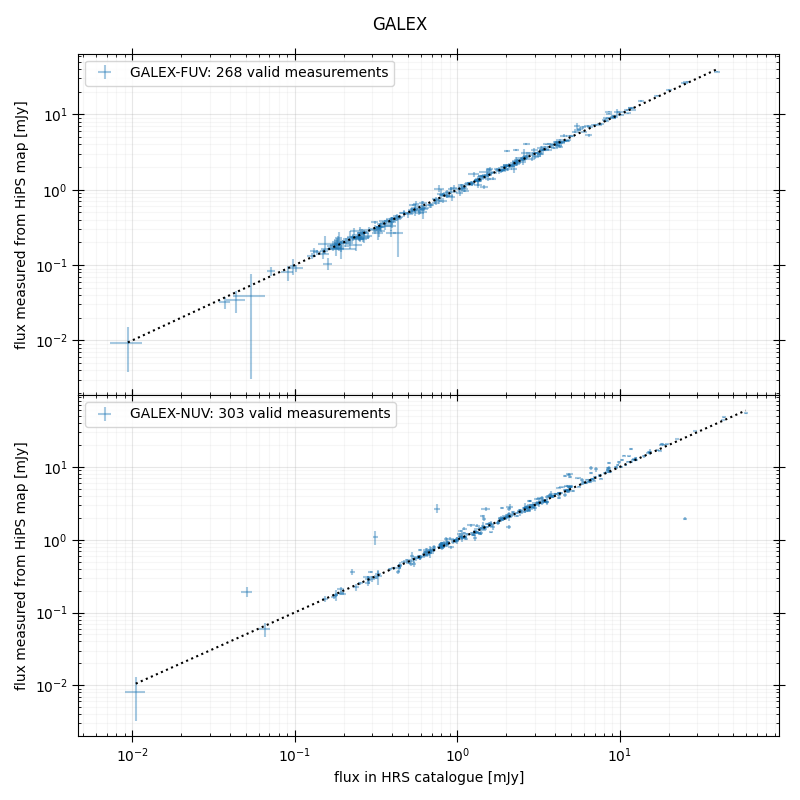

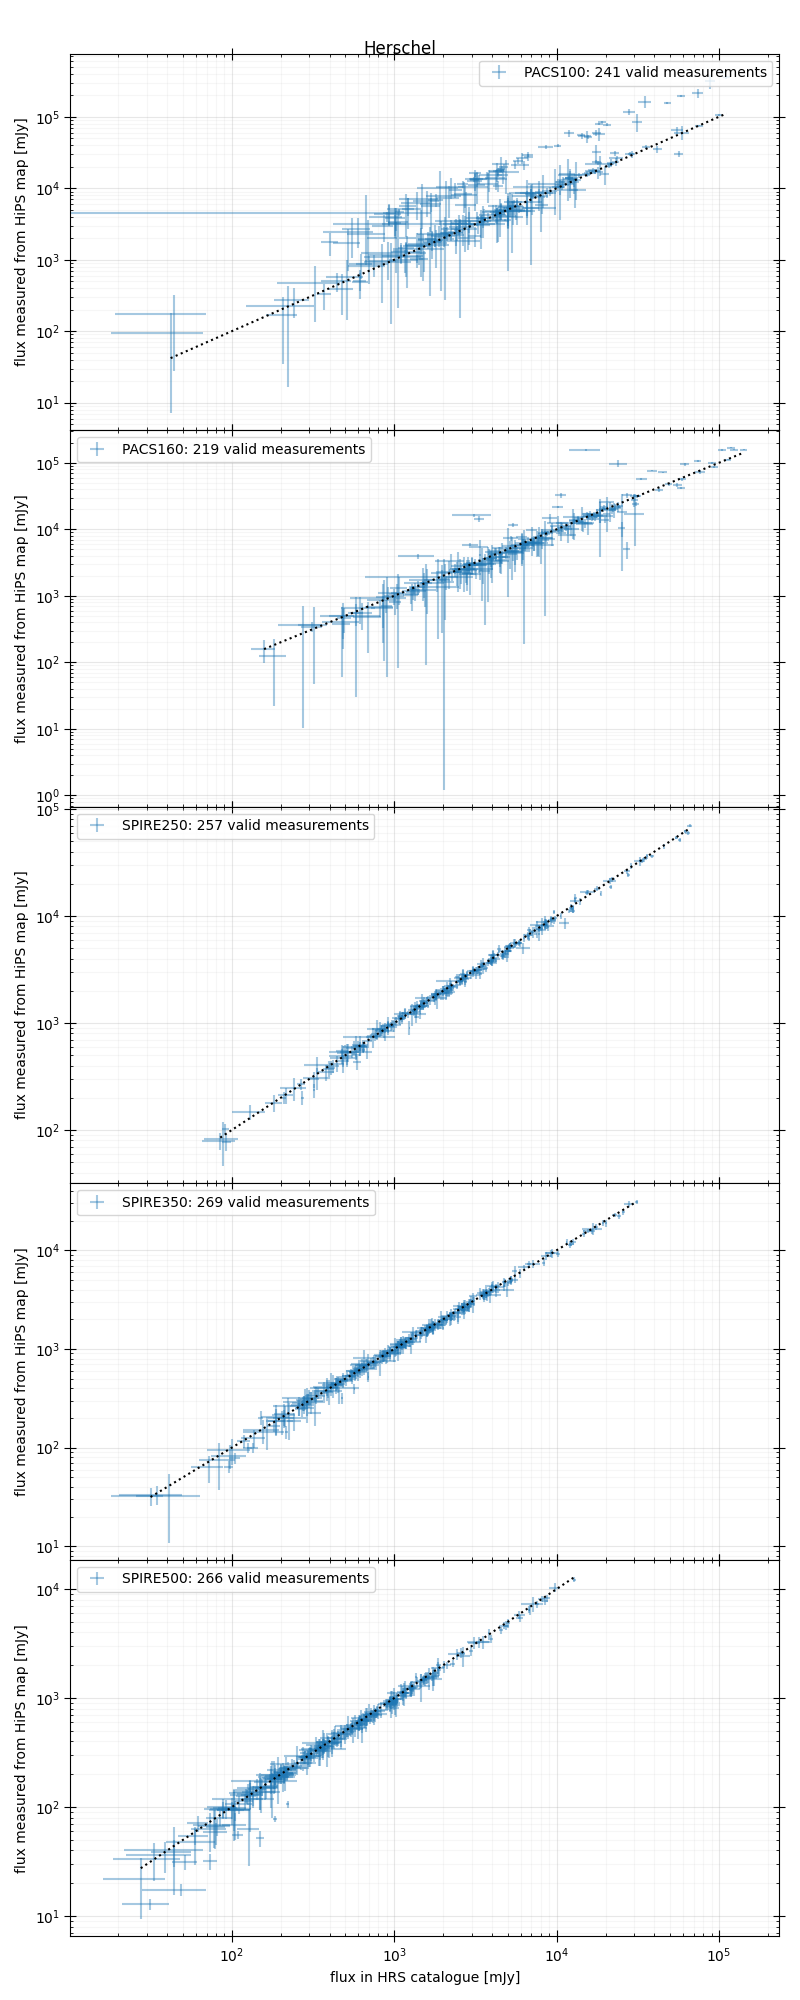

In [33]:
plot_fluxes('GALEX', ['GALEX-FUV', 'GALEX-NUV'], output_dir)
plot_fluxes('Herschel', ['PACS100', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500'], output_dir)

In [34]:
def plot_distribution(axes, band, colour, x, labels=True):
    '''Plot histogram and cumulative distribution'''

    p16, p50, p84 = np.nanpercentile(x, [16, 50, 84])
    mu = p50
    var = ((p84 - p16) / 2)**2
    print(band, p16, p50, p84)
    #bins = np.linspace(.5, 1.5, 41)
    bins = np.linspace(p16 - 4*(p50-p16), p84 + 4*(p84-p50), 50)
    x_bins = (bins[1:] + bins[:-1]) / 2

    ax = axes[0]
    if labels:
        ax.set_ylabel('fraction')
    ax.plot(np.sort(x), np.arange(x.size)/x.size, c=colour, ls='-', label=band)
            #label=f'$p_{{[16, 50, 84]}}$ = [{p16:.3g}, {p50:.3g}, {p84:.3g}]')
    #ax.axvline(p16, c=colour, ls=':')
    #ax.axvline(p50, c=colour, ls='--')
    #ax.axvline(p84, c=colour, ls=':')
    #ax.plot(bins, .5 + .5*special.erf((bins-mu)/np.sqrt(2*var)), 'k--', alpha=.2)
            #label=f'$\mu={mu:.3g}$, $\sigma={np.sqrt(var):.3g}$')
    if labels:
        ax.legend()
    ax.grid(alpha=.2)

    ax = axes[1]
    #ax.set_ylabel('number of galaxies')
    if labels:
        ax.set_ylabel('probability')
    ax.set_xlim(bins[0], bins[-1])
    #ax.axvline(p16, c='k', ls=':')
    #ax.axvline(p50, c='k', ls='--', label=f'$p_{{[16, 50, 84]}}$ = [{p16:.3g}, {p50:.3g}, {p84:.3g}]')
    #ax.axvline(p84, c='k', ls=':')
    hist, bins = np.histogram(x, bins=bins, density=True)
    ax.plot(x_bins, hist, alpha=.5, color=colour)
    ax.set_yscale('log')
    #ax.hist(x, bins=bins, density=True, alpha=.5, color=colour)
    #ax.plot(bins, np.exp(-.5*(bins-p50)**2/var) / np.sqrt(2*np.pi*var), c=colour, ls='--', alpha=.2)

    
def plot_band_flux_comparison(axes, band, colour, output_dir):

    t = QTable.read(os.path.join(output_dir, f'{band}_photometry.fits'))
    HiPS_flux = t[f'{band}_flux'].to_value(u.mJy)
    HiPS_error = t[f'{band}_flux_error'].to_value(u.mJy)
    HRS_flux = t[f'{band}_true_flux'].to_value(u.mJy)
    HRS_error = t[f'{band}_true_err'].to_value(u.mJy)
    good = (HRS_error > 0)
    good &= (HiPS_flux > HiPS_error)

    x = np.array((HiPS_flux[good] / HRS_flux[good]).data)
    plot_distribution(axes[:, 0], band, colour, x)
    
    x = np.array((HiPS_flux[good] - HRS_flux[good]).data) / HiPS_error[good]
    plot_distribution(axes[:, 1], band, colour, x, labels=False)
    
    
def plot_flux_comparison(bands, colours, output_dir):
    
    fig, axes = new_figure('flux_comparison', nrows=2, ncols=2, figsize=(8, 8))
    for i in range(len(bands)):
        plot_band_flux_comparison(axes, bands[i], colours[i], output_dir)

    ax = axes[-1, 0]
    ax.set_xlabel('HiPS flux / HRS flux')
    ax.set_xlim(.45, 1.55)
    bins = np.linspace(.45, 1.55, 201)
    mu = 1
    var = .01
    ax.plot(bins, np.exp(-.5*(bins-mu)**2/var) / np.sqrt(2*np.pi*var), c='k', ls='--', alpha=.2, label=f'$\mu$={mu:.3g} $\sigma$={np.sqrt(var):.3g}')
    ax.legend()
    ax.set_ylim(.005, 25)

    ax = axes[-1, 1]
    ax.set_xlabel('(HiPS flux - HRS flux) / HiPS error')
    ax.set_xlim(-5.5, 5.5)
    bins = np.linspace(-5.5, 5.5, 201)
    mu = 0
    var = 1
    ax.plot(bins, np.exp(-.5*(bins-mu)**2/var) / np.sqrt(2*np.pi*var), c='k', ls='--', alpha=.2, label=f'$\mu$={mu:.3g} $\sigma$={np.sqrt(var):.3g}')
    ax.legend()


GALEX-FUV 0.9129301073910988 1.0000118059456742 1.072950922362868
GALEX-FUV -1.5249805407126555 0.00014165669788824935 1.4890925545840499
GALEX-NUV 0.9579614262688191 1.0180448209717745 1.110406433905473
GALEX-NUV -0.9337962454269646 0.3614144962437913 2.906565463851431
PACS100 0.9581301372688058 1.1511376037954224 4.009851669613941
PACS100 -0.14410030974207508 0.5718646305098326 3.5133437563678678
PACS160 0.8113763710821752 0.9349039470456374 1.1056474706705428
PACS160 -1.0486664774910128 -0.2563762260640175 0.6661344051652964
SPIRE250 0.9198116937930452 0.9802361202066242 1.0313586104874757
SPIRE250 -1.0977658395535619 -0.2300748243423978 0.29709164290453877
SPIRE350 0.9264998004106879 0.9860416026030551 1.028363870120153
SPIRE350 -0.6689603002062635 -0.12511926832735007 0.2072352997955249
SPIRE500 0.9072240041206728 0.9577257032491608 1.0196400583082734
SPIRE500 -0.6610954665941621 -0.2816518997176761 0.11027833344495488


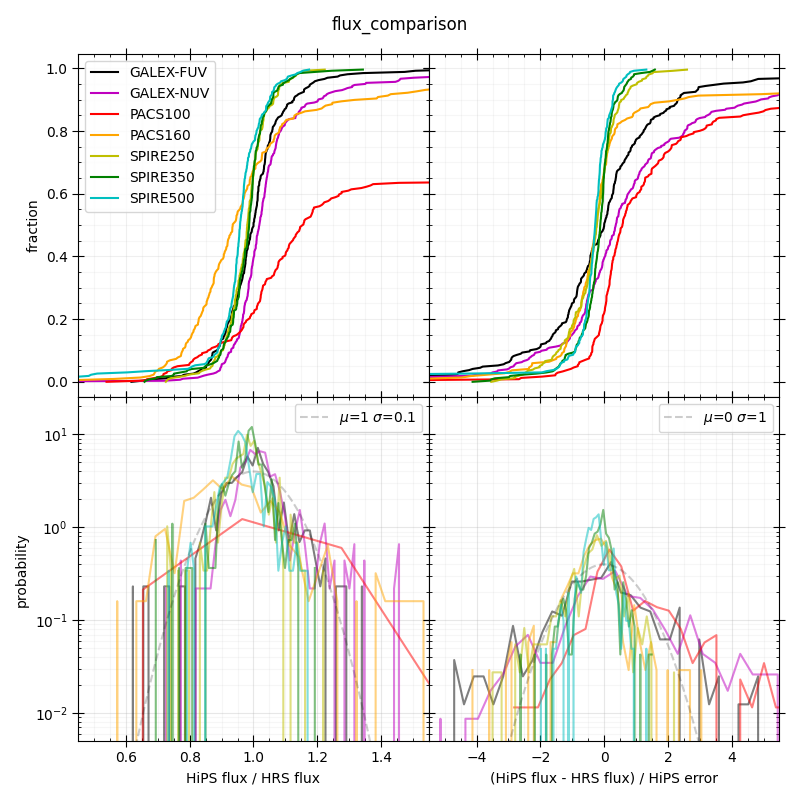

In [35]:
bands = ['GALEX-FUV', 'GALEX-NUV', 'PACS100', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
colours = ['k', 'm', 'r', 'orange', 'y', 'g', 'c']
plot_flux_comparison(bands, colours, output_dir)